# Tutorial

This notebook demonstrates the usage of `redshifted_gaussian_fields` to generate realizations of an intensity field on the sky generated by redshifted 21cm emission with a chosen power spectrum.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-Power-Spectrum" data-toc-modified-id="Define-Power-Spectrum-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define Power Spectrum</a></span></li><li><span><a href="#Compute-Cross-frequency-Covariance" data-toc-modified-id="Compute-Cross-frequency-Covariance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compute Cross-frequency Covariance</a></span></li><li><span><a href="#Generate-Random-Realizations" data-toc-modified-id="Generate-Random-Realizations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate Random Realizations</a></span></li><li><span><a href="#Save-and-Restore-Completed-Calculations" data-toc-modified-id="Save-and-Restore-Completed-Calculations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save and Restore Completed Calculations</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import cosmology

In [3]:
from redshifted_gaussian_fields import generator

In [4]:
import os, h5py

In [5]:
plt.rcParams['figure.figsize'] = [10,8]

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'

In [6]:
def plot_power_spectrum(k_axis, Pspec):
    plt.plot(k_axis, Pspec(k_axis), label=r'$P(k)$')
    plt.plot(k_axis, (k_axis/0.2)**(-2.7), label=r'$ \propto k^{-2.7}$')

    plt.legend(loc='upper right', fontsize=16)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1e-6,1e4)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)',fontsize=20)
    plt.ylabel(r'$P(k)$ (K$^2$)',fontsize=20)
    
    plt.show()

## Define Power Spectrum

Begin by defining the power spectrum. In this example we will choose a power spectrum that is effectively a power law over the given range.

In [7]:
k0 = np.logspace(-2.,1.,11)
a = k0**(-2.7)

normalization_point = 0.2
normalization_amplitude = 1.

Pspec = generator.ParameterizedGaussianPowerSpectrum(a, k0, renormalization=(normalization_point, normalization_amplitude), term_type='flat_gauss')

In [8]:
k_axis = np.logspace(-2.5,1.5,1001)

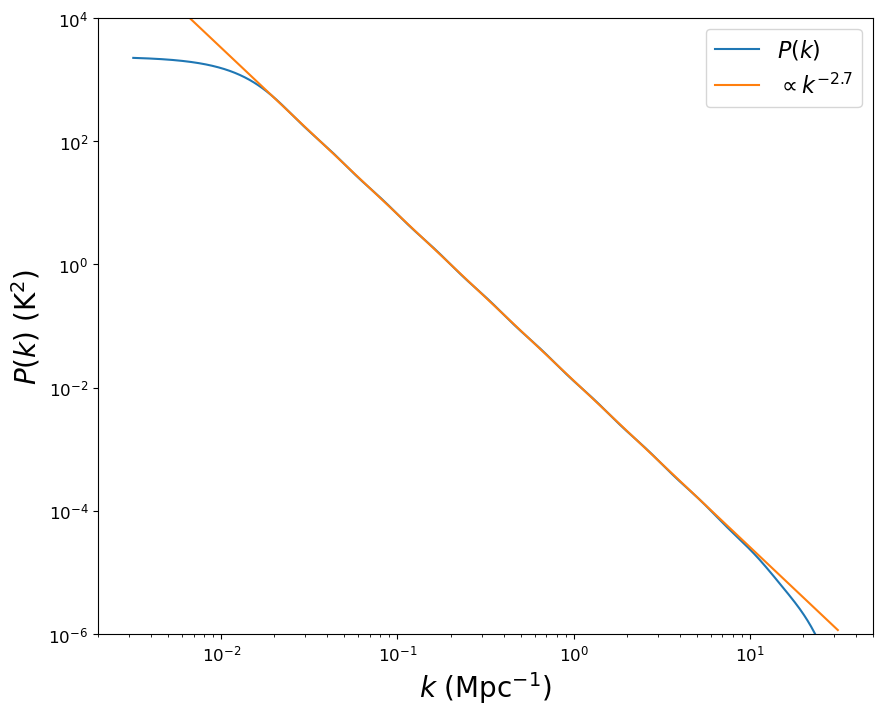

In [9]:
plot_power_spectrum(k_axis, Pspec)

The components used to define the power spectrum do not span all the possible power spectra, but they are flexible enough to produce a variety of forms. For example, we might add a run on the spectral index:

In [10]:
# Using the same locations parameters,but with a different set
# of amplitude parameters
a_2 = k0**(-2.7 - 0.1*np.log(k0))

Pspec_2 = generator.ParameterizedGaussianPowerSpectrum(a_2, k0, renormalization=(normalization_point, normalization_amplitude), term_type='flat_gauss')

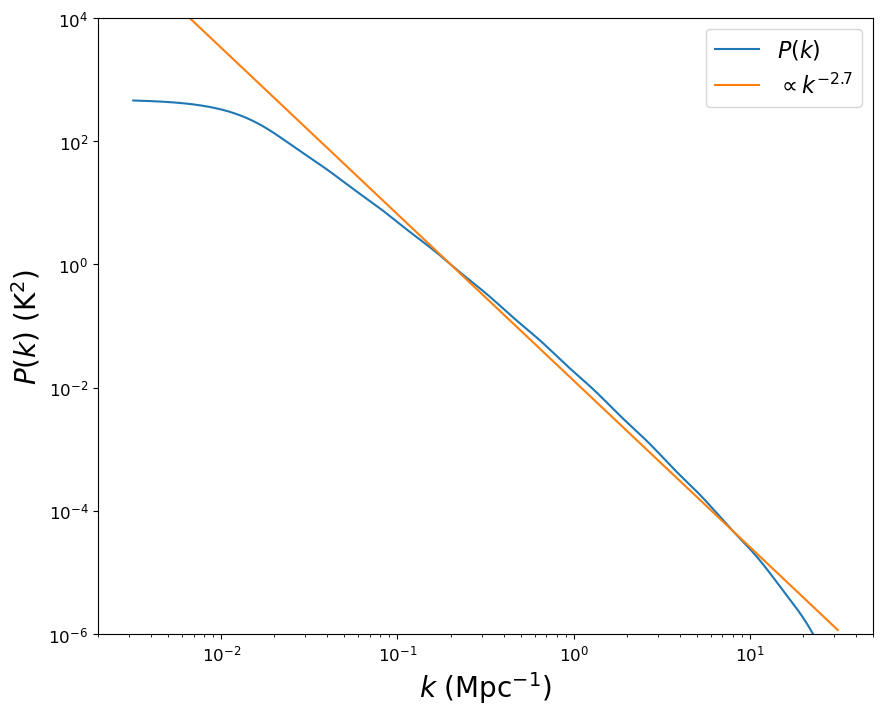

In [11]:
plot_power_spectrum(k_axis, Pspec_2)

## Compute Cross-frequency Covariance

Next we choose the parameters over which to evaluate the cross-covariance function which is used to produce sky model realizations.

Frequency $\nu$ points in MHz, 140MHz to 150MHz with a channel width of 0.1MHz:

In [12]:
nu_axis = np.linspace(140., 150., 101, endpoint=True)
del_nu = 0.1

Angular harmonic order $\ell$, from 0 to 100

In [13]:
ell_axis = np.arange(101)

A choice of cosmological parameters is needed to specify the comoving distance $r$ as a function of $\nu$. This package uses an `astropy` cosmology object for this purpose:

In [14]:
cosmo = cosmology.Planck15

Choose the number of samples used to compute the frequency channel integrals

In [15]:
Np = 15

Now we can initialize a GaussianCosmologicalFieldGenerator object, which is used to manage the various computations and well as saving to disk and restoring completed calculations.

In [16]:
gcfg = generator.GaussianCosmologicalFieldGenerator(cosmo, Pspec, nu_axis, del_nu, ell_axis, Np=Np)

Then we can compute the cross-frequency angular power spectrum over the specified parameter domain for the chosen 3D power spectrum `Pspec`. This is most computationally intensive step and for useful ranges of the parameters may take minutes to hours depending on the number of frequency samples, angular modes, number of terms in the power spectrum function, number of points used in the channelization integral, and whether a matrix element cutoff value $\epsilon$ can be effectively utilized.

In [17]:
%%time
gcfg.compute_cross_frequency_angular_power_spectrum()

CPU times: user 2min 47s, sys: 0 ns, total: 2min 47s
Wall time: 29.5 s


The computational scaling in terms of
* $N_\nu$, the number of frequency samples
* $N_\ell$, the number of angular modes
* $N_i$, the number of power spectrum terms
* $N_p$, the number of samples per frequency channel

is approximately $\mathcal{O}(N_\nu^2 N_\ell N_i N_p^2)$ if $\epsilon = 0$. However if $\epsilon > 0$, it becomes $\sim \mathcal{O}(N_\nu N_\ell N_i N_p^2)$, with an overall nearly-constant factor that depends on $\epsilon$ and the small-$k_0$ extent of the power spectrum.

The computed cross-frequency angular power spectrum is stored in a $N_\ell \times N_\nu \times N_\nu$ array

In [18]:
print(gcfg.barC.shape)

(101, 101, 101)


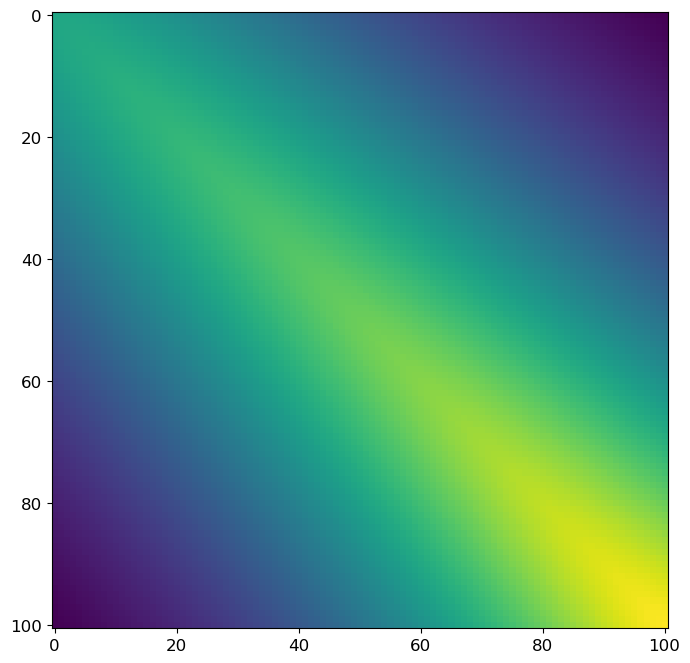

In [19]:
plt.imshow(gcfg.barC[50]);

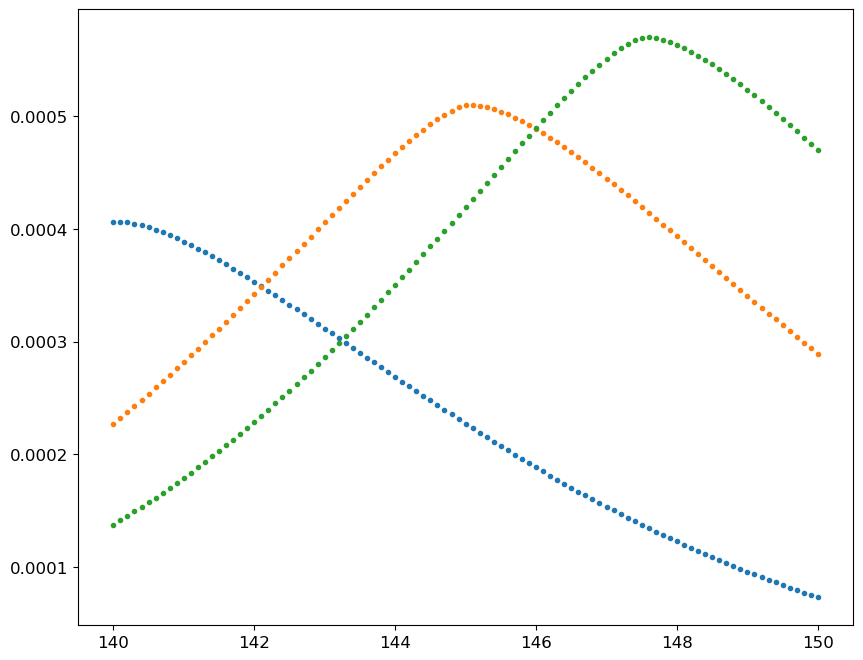

In [20]:
plt.plot(gcfg.nu_axis, gcfg.barC[50,0,:], '.')
plt.plot(gcfg.nu_axis, gcfg.barC[50,50,:], '.')
plt.plot(gcfg.nu_axis, gcfg.barC[50,75,:], '.');

## Generate Random Realizations

Generate realizations of the harmonic coefficients of the specific intensity of the sky. Each realization is generated from the input random seed so that the same realization can be re-generated on demand.

In [21]:
seed = 2983
a_lm = gcfg.generate_realization(seed)

Eigen-decomposition not yet set. Starting computation...
Eigen-decomposition done.


In [22]:
a_lm2 = gcfg.generate_realization(seed)

In [23]:
np.allclose(a_lm, a_lm2)

True

Generate a healpix map sampling of the specific intensity with resolution specified by `nside`:

In [24]:
nside = 128
hmap = gcfg.generate_healpix_map_realization(seed, nside)

The first axis of the array is frequnency, the second axis is healpix pixels.

In [25]:
print(hmap.shape, hmap.dtype)

(101, 196608) float64


The frequency spectrum of at a point in the map:

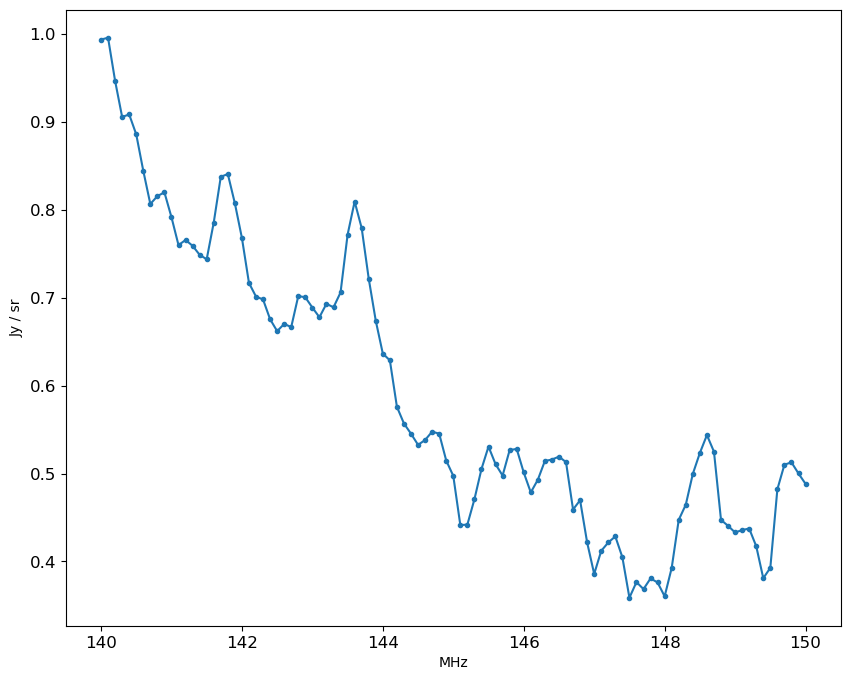

In [26]:
plt.plot(gcfg.nu_axis, hmap[:,0], '.-')
plt.ylabel('Jy / sr')
plt.xlabel('MHz');

## Low-memory Realization Generation

In [27]:
test_file_path = os.path.join(os.getcwd(), 'test_file.h5'); test_file_path

gcfg.generate_healpix_map_realization_low_memeory(seed, nside, test_file_path, overwrite=True)

In [28]:
with h5py.File(test_file_path, 'r') as h5f:
    hmap2 = h5f['healpix_maps'][()]
    
np.allclose(hmap, hmap2)

True

## Save and Restore Completed Calculations